# Projet

### Imports

In [1]:
# Imports
import glob, os
import pandas
import urllib
from SPARQLWrapper import SPARQLWrapper
import PIL.Image
from skimage import io
import ipywidgets

## 1. Collecte de données

### Dataframe Functions

In [2]:
def jsonToDataframe(path):   
    with open(path, "r", encoding="utf-8") as f:
        dataframe = pandas.read_json(f, orient='index')
    return dataframe

def dataframeToJson(path, dataframe):   
    with open(path, "w", encoding="utf-8") as f:
        f.write(dataframe.to_json(orient='index', indent=2))

### Récupération du résultat d'une query Wikidata

In [3]:
size = 5
dataPath = "data.json"
imagesPath = "./images/"

# Query de Wikidata
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
query = """
SELECT ?item ?itemLabel ?pic WHERE {
  ?item wdt:P31 wd:Q4989906;
    wdt:P18 ?pic.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
LIMIT """
# On précise le nombre d'entrées que l'on veut
query = query + str(size)

# On récupère le résultat de la query
sparql.setQuery(query)
sparql.setReturnFormat("json")
results = sparql.query().convert()

# On normalise les résultat pour pandas
array = []
for data in results["results"]["bindings"]:
    name = data["itemLabel"]["value"]
    format = data["pic"]["value"].split(".")[-1]
    path = f"{imagesPath}{name}.{format}"

    array.append([name,  
                  data["pic"]["value"], 
                  data["item"]["value"].split(sep='/')[-1],
                  format,
                  path,
                  (),
                  None,
                  ['#monument']])
                  

dataframe = pandas.DataFrame(array, columns=["label", "link", "entityID", "format", "path", "size", "sizeCategory", "tags"])

# On enregistre les données au format JSON
dataframeToJson(dataPath, dataframe)

# Nettoyage du dossier /images
if not os.path.isdir('./images'):
  os.mkdir('./images')

# Nettoyage du dossier /images
else:
  files = glob.glob('./images/*')
  for f in files:
      os.remove(f)



dataframe


,label,link,entityID,format,path,size,sizeCategory,tags
0,Canale dei Buranelli,http://commons.wikimedia.org/wiki/Special:File...,Q5583,jpg,./images/Canale dei Buranelli.jpg,(),None,[#monument]
1,Monument to Pedro IV (Porto),http://commons.wikimedia.org/wiki/Special:File...,Q11783,JPG,./images/Monument to Pedro IV (Porto).JPG,(),None,[#monument]
2,Sunken Ships Monument,http://commons.wikimedia.org/wiki/Special:File...,Q14681,jpg,./images/Sunken Ships Monument.jpg,(),None,[#monument]
3,Lu Xun Memorial Hall,http://commons.wikimedia.org/wiki/Special:File...,Q23180,jpg,./images/Lu Xun Memorial Hall.jpg,(),None,[#monument]
4,Slovak monument,http://commons.wikimedia.org/wiki/Special:File...,Q25477,jpg,./images/Slovak monument.jpg,(),None,[#monument]


### Téléchargement des Images

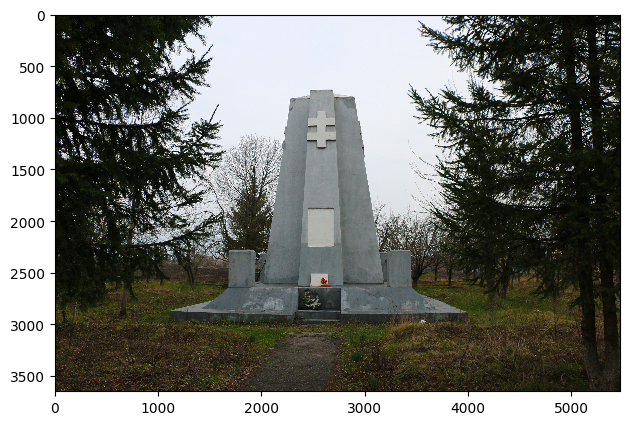

In [4]:
dataframe = jsonToDataframe(dataPath)
for i in range(len(dataframe.index)):
    # On télécharge l'image
    link = dataframe._get_value(i,"link")
    path = dataframe._get_value(i,"path")
    response = urllib.request.urlretrieve(link, path)


 
img = io.imread(path)
io.imshow(img)

### Récupération des Données EXIFS

In [5]:
dataframe = jsonToDataframe(dataPath)

wantedExifs = [274, 315, 306, 272]
columnNames = ["orientation", "artist", "date", 'appareil']

for i,tag in enumerate(wantedExifs):
    dataframe[columnNames[i]] = None
    

# On parcours les entrées
for i in range(len(dataframe.index)):
    path = dataframe._get_value(i,"path")
    img = PIL.Image.open(path)
    exif_data = img._getexif()
    img.close()

    dataframe.at[i, "size"] = img.size
    if img.size[0] < img.size[1]:
        dataframe.at[i, "orientation"] = 0
    else:
        dataframe.at[i, "orientation"] = 1

    if exif_data:
      for tag in exif_data:
            if tag in wantedExifs:
                dataframe.at[i, columnNames[wantedExifs.index(tag)]] = exif_data[tag]
                
dataframe.astype({'orientation': 'int32'})

# On enregistre les données au format JSON
dataframeToJson(dataPath, dataframe)
        
dataframe 

,label,link,entityID,format,path,size,sizeCategory,tags,orientation,artist,date,appareil
0,Canale dei Buranelli,http://commons.wikimedia.org/wiki/Special:File...,Q5583,jpg,./images/Canale dei Buranelli.jpg,"(6048, 4032)",NaN,[#monument],1,None,2011:05:15 19:43:53,DSLR-A850
1,Monument to Pedro IV (Porto),http://commons.wikimedia.org/wiki/Special:File...,Q11783,JPG,./images/Monument to Pedro IV (Porto).JPG,"(800, 600)",NaN,[#monument],1,None,2006:05:01 10:11:42,CYBERSHOT
2,Sunken Ships Monument,http://commons.wikimedia.org/wiki/Special:File...,Q14681,jpg,./images/Sunken Ships Monument.jpg,"(2500, 3333)",NaN,[#monument],1,None,2012:09:30 17:43:55,Canon PowerShot SX40 HS
3,Lu Xun Memorial Hall,http://commons.wikimedia.org/wiki/Special:File...,Q23180,jpg,./images/Lu Xun Memorial Hall.jpg,"(2000, 1125)",NaN,[#monument],1,Picasa,2011:10:30 21:36:27,DMC-LX5
4,Slovak monument,http://commons.wikimedia.org/wiki/Special:File...,Q25477,jpg,./images/Slovak monument.jpg,"(5472, 3648)",NaN,[#monument],1,PRYMASAL,2017:05:19 13:01:26,Canon EOS 70D


## Analyse des Données

In [6]:
# Création de la dataframe des utilisateurs
usersPath = 'users.json'

array = [['default',[]]]
usersDataframe = pandas.DataFrame(array, columns=['username', 'likedImages'])

dataframeToJson(usersPath, usersDataframe)

usersDataframe

,username,likedImages
0,default,[]


## Test Interaction

In [7]:
images = glob.glob('./images/*')
images

['./images\\Canale dei Buranelli.jpg',
 './images\\Lu Xun Memorial Hall.jpg',
 './images\\Monument to Pedro IV (Porto).JPG',
 './images\\Slovak monument.jpg',
 './images\\Sunken Ships Monument.jpg']

In [22]:
layout =  ipywidgets.GridspecLayout(n_columns=3, n_rows=len(images), height='400px')

for i, img in enumerate(images):
  file = open(img, "rb")
  image = file.read()
  file.close()
  image_widget = ipywidgets.widgets.Image(
    value=image,
    format='png'
  )
  layout[i//3, i%3] = image_widget


# Button to get selected images
button = ipywidgets.Button(description="Select")

# Output widget to display selected images
output = ipywidgets.Output()
        
# Display the layout and button
display(layout, button, output)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe1\x1d_Exif\x00\x00II*\x00\x08\x00\x00\x00\n\x00\x0e\x01\…

Button(description='Select', style=ButtonStyle())

Output()